This notebook was used for the initial analysis of creating the dashboard on well being Time series. Two datasets were used here, both were extracted from the aprtojune24nonseasonallyadjusted.xlsx file. 

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel(r'/Users/mac/Downloads/time_series_record.xlsx')

In [4]:
df.head()

,Time period,Average Life satisfaction,Average Worthwhile,Average happiness,Average anxiety
0,2011-04-01,7.4,7.6,7.3,3.2
1,2011-07-01,7.4,7.7,7.3,3.1
2,2011-10-01,7.4,7.7,7.2,3.1
3,2012-01-01,7.4,7.7,7.3,3.1
4,2012-04-01,7.4,7.7,7.3,3.1


The dataset loaded above contains the average life satisfaction, worthwhile, happiness and anxiety within the specified quarterly periods given in the dataset

In [5]:
print(df.info())

print(df.isnull().sum())

print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Time period                53 non-null     datetime64[ns]
 1   Average Life satisfaction  53 non-null     float64       
 2   Average Worthwhile         53 non-null     float64       
 3   Average happiness          53 non-null     float64       
 4   Average anxiety            53 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.2 KB
None
Time period                  0
Average Life satisfaction    0
Average Worthwhile           0
Average happiness            0
Average anxiety              0
dtype: int64
0


All the data types are in the right type, no missing value and there is no duplicate

In [6]:
df = df.set_index('Time period')

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Average Life satisfaction,53.0,7.560377,0.116585,7.3,7.5,7.6,7.7,7.7
Average Worthwhile,53.0,7.798113,0.077187,7.6,7.7,7.8,7.9,7.9
Average happiness,53.0,7.418868,0.102012,7.2,7.3,7.4,7.5,7.6
Average anxiety,53.0,3.035849,0.165360,2.8,2.9,3.0,3.2,3.4


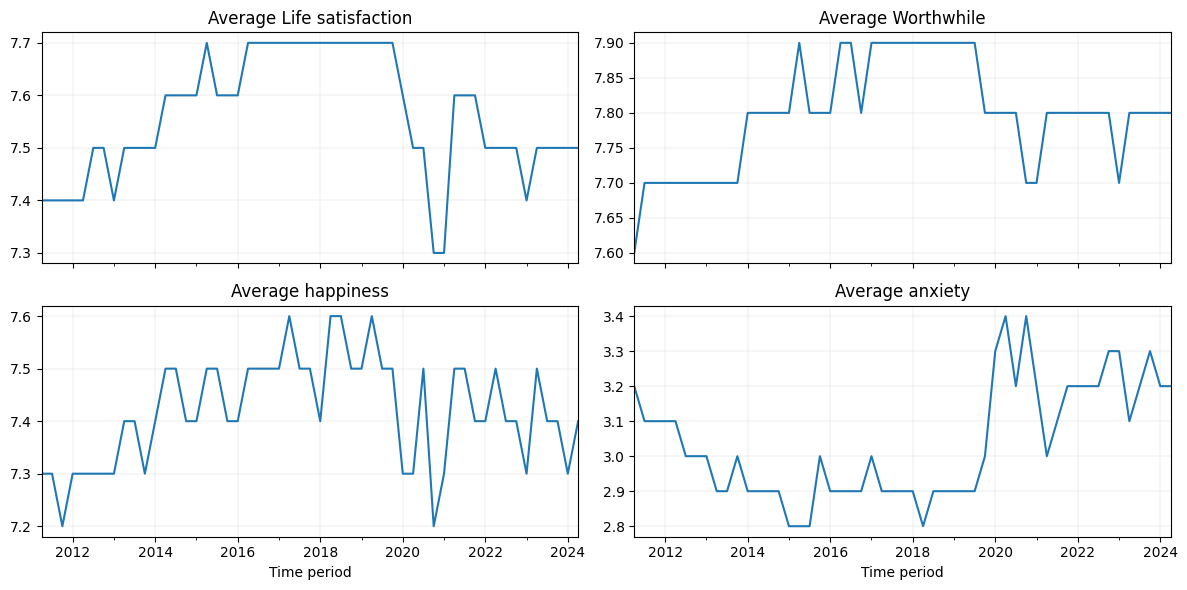

In [8]:
vars_to_plot = df.columns.tolist()
n = len(vars_to_plot)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), sharex=True)

for ax, col in zip(axes.flatten(), vars_to_plot):
    df[col].plot(ax=ax)
    ax.set_title(col)
    ax.set_ylabel("")     
    ax.grid(True, linewidth=0.3, alpha=0.5)

# if there are any empty subplots, remove them
for ax in axes.flatten()[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

The plots above are the time plot of the origiinal series. 

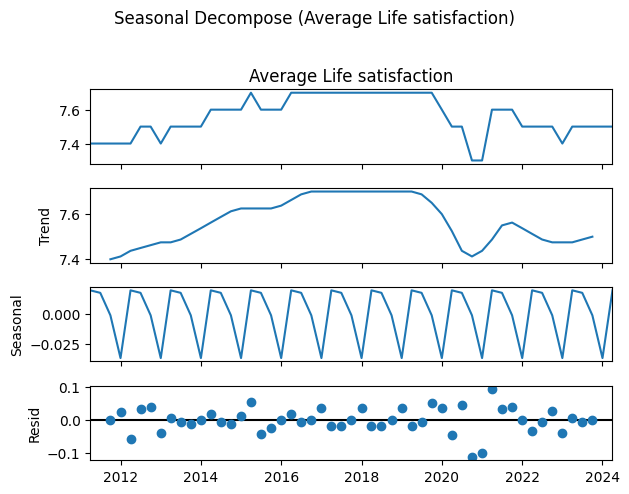

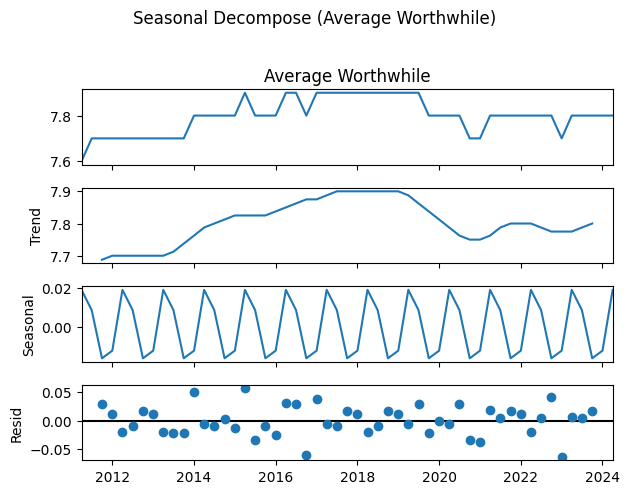

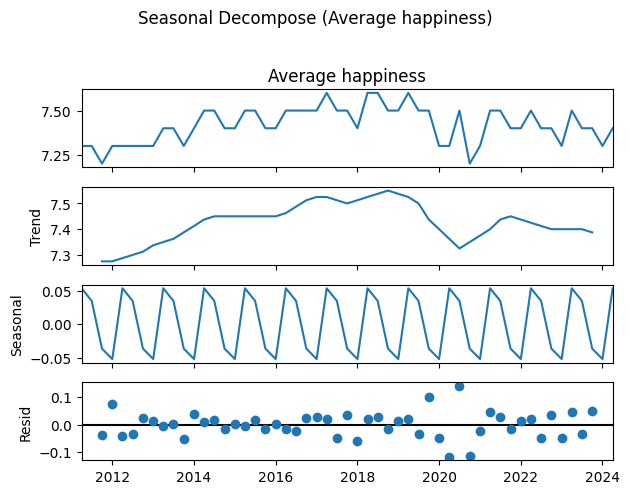

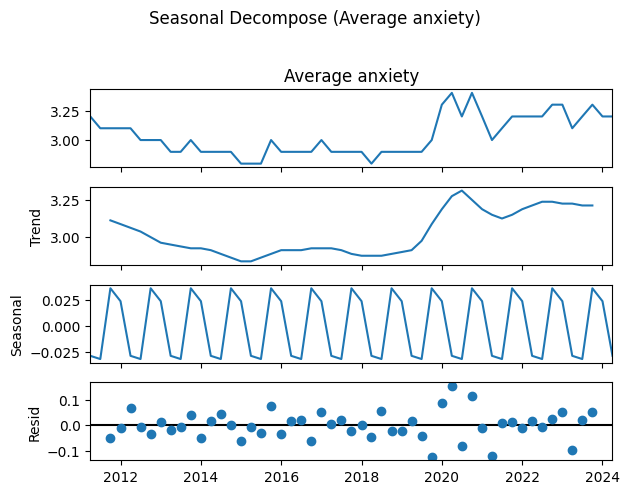

In [10]:
for col in df:
    decomp = seasonal_decompose(df[col], model='additive', period=4)
    decomp.plot()
    plt.suptitle(f"Seasonal Decompose ({col})", y=1.02)
    plt.tight_layout()
    plt.show()

In [11]:
df.columns

Index(['Average Life satisfaction', 'Average Worthwhile', 'Average happiness',
       'Average anxiety'],
      dtype='object')

In [12]:
#Stationarity test on the original series
for col in df:
    print (f"Stationarity test for {col}")
    p_value = round(adfuller(df[col])[1], 2)
    print(f'p_value for {col}: {p_value}')

Stationarity test for Average Life satisfaction
p_value for Average Life satisfaction: 0.13
Stationarity test for Average Worthwhile
p_value for Average Worthwhile: 0.26
Stationarity test for Average happiness
p_value for Average happiness: 0.38
Stationarity test for Average anxiety
p_value for Average anxiety: 0.18


The stationarity test on the original series shows that all the four series are not stationary at d = 0. This means that differencing is needed.

In [13]:
#Stationarity test at first differencing, d=1
for col in df:
    print (f"Stationarity test for {col}")
    p_value = round(adfuller(df[col].diff().dropna())[1], 2)
    print(f'p_value for {col}: {p_value}')

Stationarity test for Average Life satisfaction
p_value for Average Life satisfaction: 0.0
Stationarity test for Average Worthwhile
p_value for Average Worthwhile: 0.14
Stationarity test for Average happiness
p_value for Average happiness: 0.26
Stationarity test for Average anxiety
p_value for Average anxiety: 0.0


At first differencing, Average life satisfaction and average anxiety became stationary (d = 1). Second differecing is needed for average worthwhile and average hapiness

In [14]:
#Stationarity test at second differencing
for col in df[['Average Worthwhile', 'Average happiness']]:
    print (f"Stationarity test for {col}")
    p_value = round(adfuller(df[col].diff().dropna().diff().dropna())[1], 2)
    print(f'p_value for {col}: {p_value}')

Stationarity test for Average Worthwhile
p_value for Average Worthwhile: 0.0
Stationarity test for Average happiness
p_value for Average happiness: 0.0


At second differencing, average worthwhile and average happiness became stationary (d = 2)


This values of d will be used in the modelling phase.

ACF and PACF for Average Life satisfaction


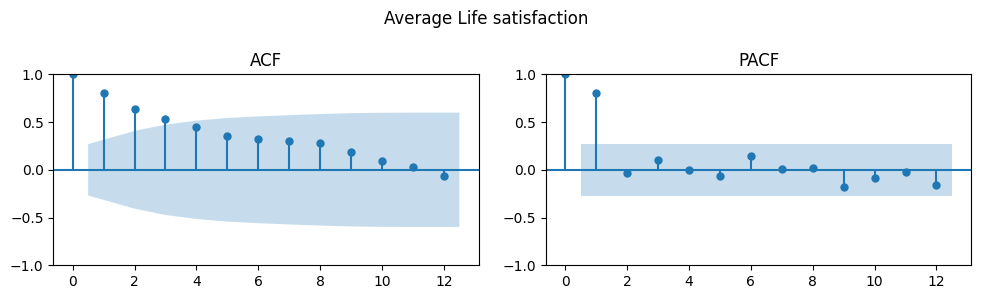

ACF and PACF for Average Worthwhile


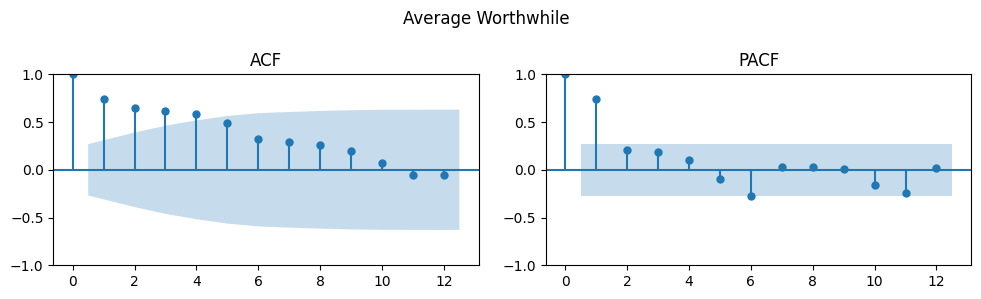

ACF and PACF for Average happiness


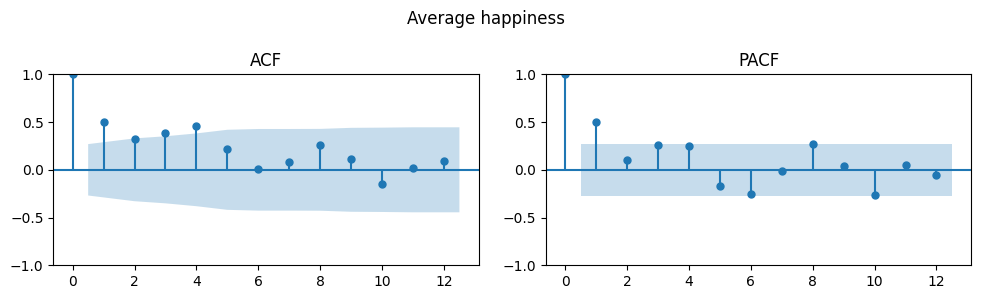

ACF and PACF for Average anxiety


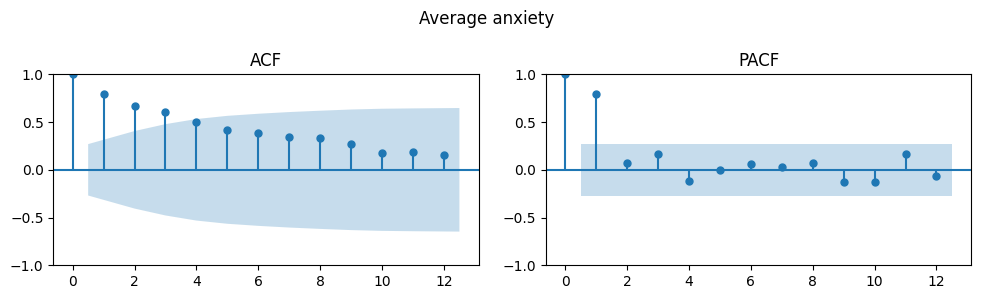

In [15]:
for col in df:
    print (f"ACF and PACF for {col}")
     # d) ACF / PACF
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    plot_acf(df[col], lags=12, ax=ax[0])
    ax[0].set_title("ACF")
    plot_pacf(df[col], lags=12, ax=ax[1])
    ax[1].set_title("PACF")
    plt.suptitle(col)
    plt.tight_layout()
    plt.show()

In [16]:
diff_orders = {
    'Average Life satisfaction': 1,
    'Average Worthwhile': 2,
    'Average happiness': 2,
    'Average anxiety': 1,
}

In [17]:
horizon = 10  

vars_ = list(diff_orders.keys())

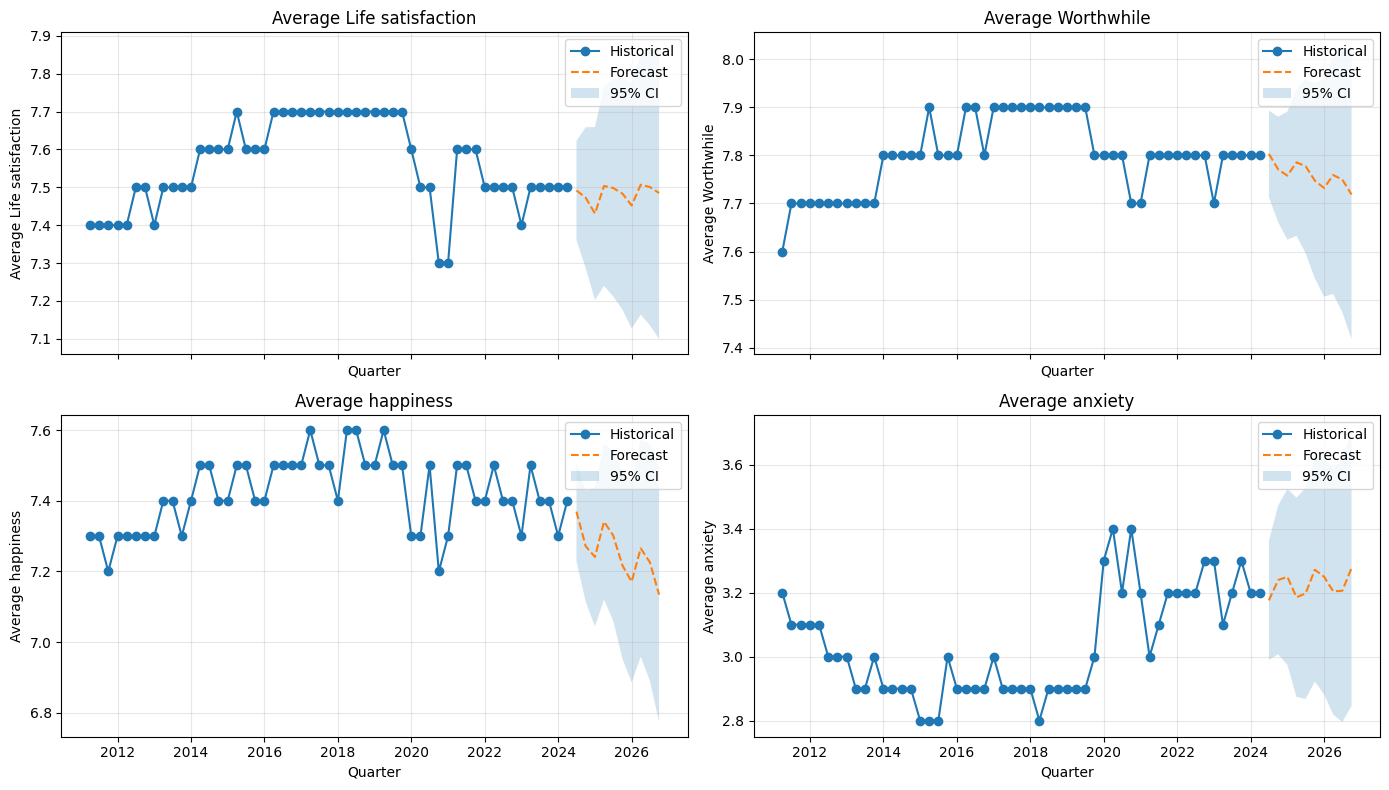

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

for ax, col in zip(axes.flatten(), vars_):
    ts = df[col].dropna()

    if len(ts) < 8:
        ax.text(0.5, 0.5, "Insufficient data for SARIMAX", ha='center', va='center')
        ax.set_title(col)
        ax.set_xlabel("Quarter")
        ax.set_ylabel(col)
        continue

    d = diff_orders.get(col, 1)

    # Fit SARIMAX model 
    model = SARIMAX(
        ts,
        order=(1, d, 1),
        seasonal_order=(1, 1, 1, 4),  # Quarterly seasonality
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Forecast and confidence intervals
    res = model.get_forecast(steps=horizon)
    fc = res.predicted_mean
    ci = res.conf_int(alpha=0.05)

    # Build datetime index for the forecast horizon
    future_idx = pd.period_range(ts.index[-1], periods=horizon + 1, freq='Q')[1:].to_timestamp()

    # Plot historical data
    ax.plot(ts.index, ts.values, marker='o', label='Historical')

    # Plot forecast with dashed line
    ax.plot(future_idx, fc.values, linestyle='--', label='Forecast')

    # Fill confidence interval
    ax.fill_between(future_idx, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2, label='95% CI')

    ax.set_title(col)
    ax.set_xlabel('Quarter')
    ax.set_ylabel(col)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
df = pd.read_csv(r'/Users/mac/Downloads/Demographic_recordscsv.csv')

In [20]:
df

,Demographic characteristic,Average Life satisfaction,Average Worthwhile,Average happiness,Average anxiety
0,16 to 19,7.7,7.7,7.7,3.4
1,20 to 24,7.1,7.4,6.8,3.9
2,25 to 29,7.4,7.6,7.4,3.7
3,30 to 34,7.5,7.8,7.5,3.4
4,35 to 39,7.5,7.8,7.5,3.3
5,40 to 44,7.4,7.7,7.3,3.4
6,45 to 49,7.4,7.8,7.3,3.2
7,50 to 54,7.3,7.7,7.3,3.4
8,55 to 59,7.4,7.8,7.5,3.0
9,60 to 64,7.6,8.0,7.6,3.0


In [21]:
age_df = df.iloc[:16]

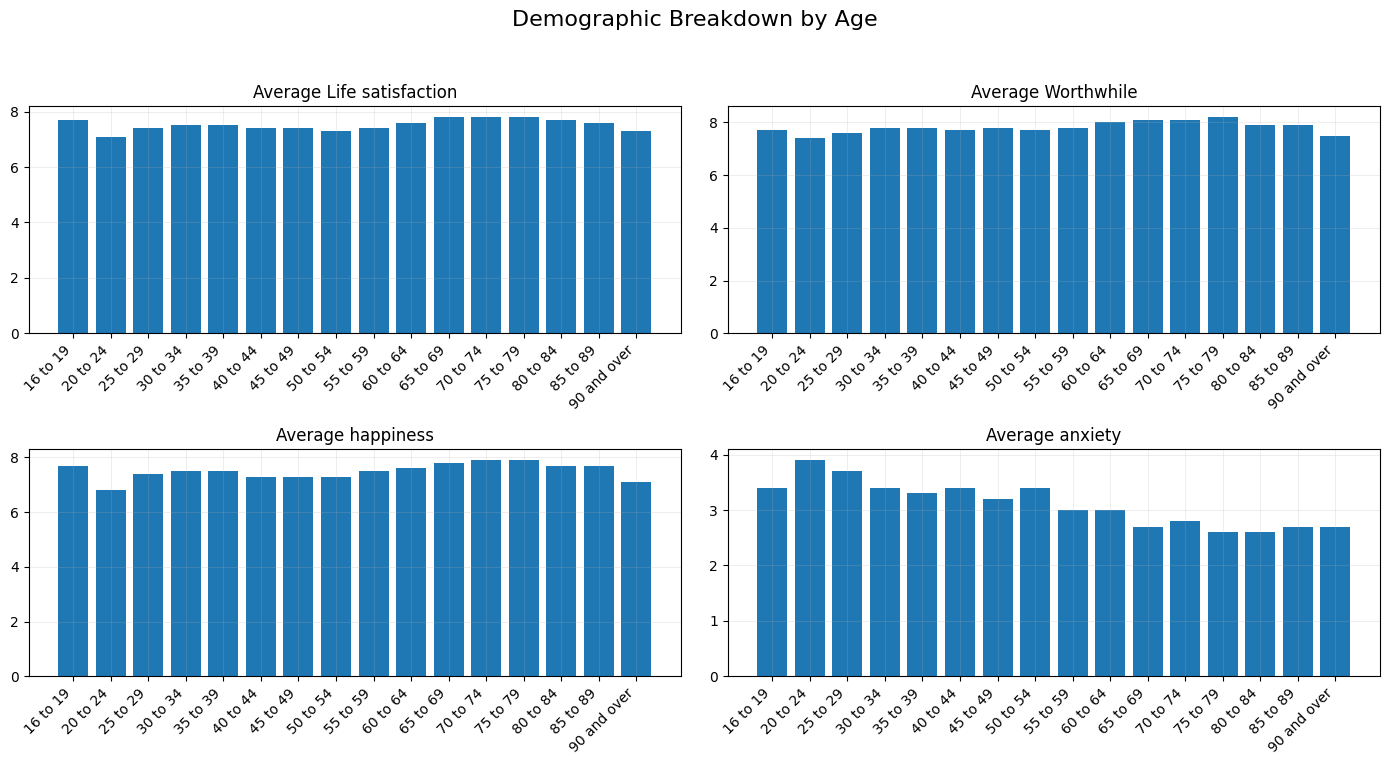

In [22]:
import matplotlib.pyplot as plt

metrics = [
    'Average Life satisfaction',
    'Average Worthwhile',
    'Average happiness',
    'Average anxiety'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=False)
fig.suptitle('Demographic Breakdown by Age', fontsize=16)

for ax, metric in zip(axes.flatten(), metrics):
    ax.bar(age_df['Demographic characteristic'], age_df[metric])
    ax.set_title(metric)
    ax.set_xticks(range(len(age_df)))
    ax.set_xticklabels(age_df['Demographic characteristic'], rotation=45, ha='right')
    ax.grid(alpha=0.3, linewidth=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [24]:
gender_df = df.iloc[16:18]

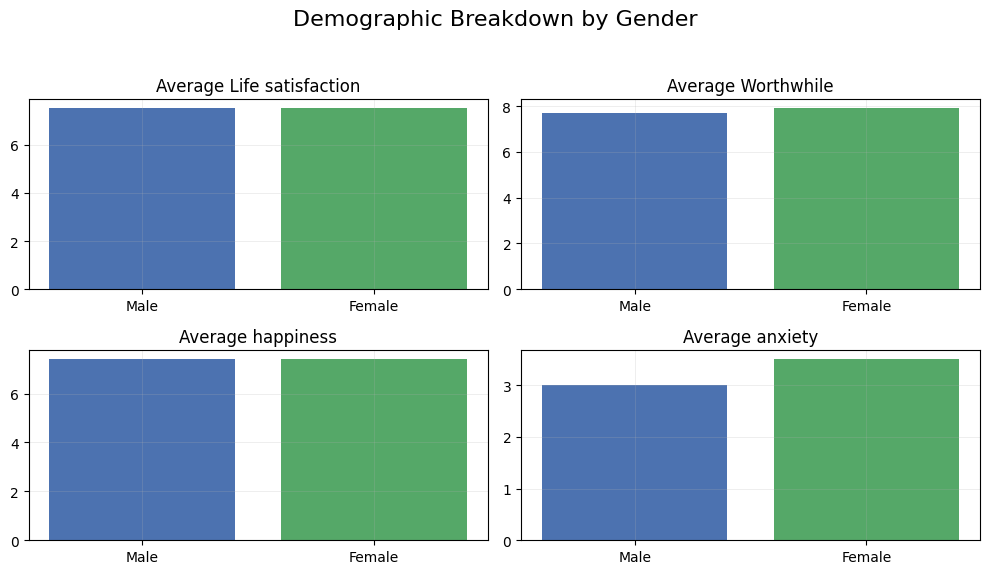

In [25]:
import matplotlib.pyplot as plt

metrics = [
    'Average Life satisfaction',
    'Average Worthwhile',
    'Average happiness',
    'Average anxiety'
]

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=False)
fig.suptitle('Demographic Breakdown by Gender', fontsize=16)

for ax, metric in zip(axes.flatten(), metrics):
    ax.bar(gender_df['Demographic characteristic'], gender_df[metric], color=['#4C72B0', '#55A868'])
    ax.set_title(metric)
    ax.grid(alpha=0.3, linewidth=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


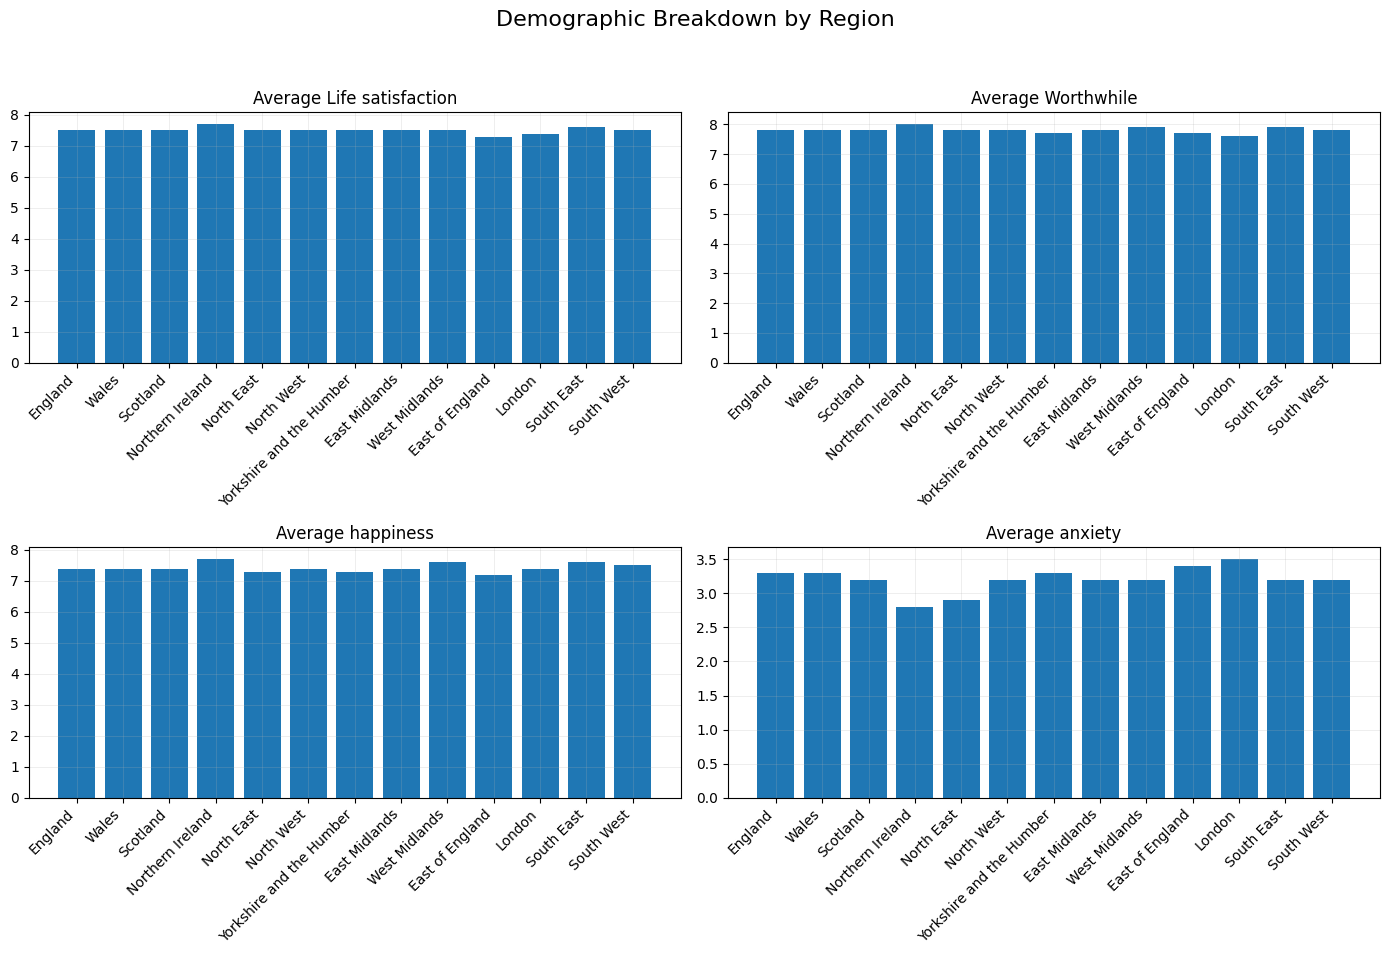

In [26]:
region_df = df.iloc[18:]

import matplotlib.pyplot as plt

metrics = [
    'Average Life satisfaction',
    'Average Worthwhile',
    'Average happiness',
    'Average anxiety'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
fig.suptitle('Demographic Breakdown by Region', fontsize=16)

for ax, metric in zip(axes.flatten(), metrics):
    ax.bar(region_df['Demographic characteristic'], region_df[metric])
    ax.set_title(metric)
    ax.set_xticks(range(len(region_df)))
    ax.set_xticklabels(region_df['Demographic characteristic'], rotation=45, ha='right')
    ax.grid(alpha=0.3, linewidth=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
